Assignment-05(mandatory) sunitachoudhary103@gmail.com

 Objective-Amazon food reviews polarity prediction based on the given review data by applying Naive Bayes algorithm. To build generalized prediction model first step should be necessary cleaning of data as a part of data preprocessing.

First clean the data ,remove duplicate entries. other Text-pre processing like.. a.Removing Stop-words b.Remove any punctuations or limited set of special characters like , or . or # etc. c.Snowball Stemming the word d.Convert the word to lowercase

Once the data is cleaned to be processed we'll use below Feature generation techniques to convert text to numeric vector.

* First sort the data by Time *split the top 10,0000 data into three parts-train,cv,test

 # 1.BOW-
    1.1 GridSearchCV-
        *L2-Regularization
        *L1-Regularization
    1.2 RandomSearchCV-
        *L2-Regularization
        *L1-Regularization
# 2.TFIDF-
    2.1 GridSearchCV-
        *L2-Regularization
        *L1-Regularization
    2.2 RandomSearchCV-
        *L2-Regularization
        *L1-Regularization
# 3.Word2Vec-
    3.1 AvgW2V-
    3.11 GridSearchCV-
        *L2-Regularization
        *L1-Regularization
    3.12 RandomSearchCV-
        *L2-Regularization
        *L1-Regularization
    3.2 TFIDF-W2V-
    3.21 GridSearchCV-
        *L2-Regularization
        *L1-Regularization
    3.22 RandomSearchCV-
        *L2-Regularization
        *L1-Regularization
    # 4.Conclusion-
     *  PrettyTables
    

In [38]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [39]:
data=sqlite3.connect("database.sqlite")

In [40]:
import pandas as pd
filtered_data=pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score !=3
""",data)
def partition(x):
    if x<3:
        return 'negative'
    return 'positive'
a_score=filtered_data["Score"]
positiveNegative=a_score.map(partition)
filtered_data["Score"]=positiveNegative

In [41]:
print(filtered_data.shape)


(525814, 10)


In [42]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [43]:
sorted_data=filtered_data.sort_values('ProductId',ascending=True,inplace=False,kind='quickSort',na_position='last')
#de duplication of entries
final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
final.shape

(364173, 10)

In [44]:
final=final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
print(final.shape)
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [45]:
%%time
import re
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stop=set(stopwords.words('english'))
print(stop)
sno=nltk.stem.SnowballStemmer('english')
print(sno.stem('tasty'))

def cleanhtml(sentence):#function to clean the word of any html-tags
    cleanr=re.compile('<.*?>')
    cleantext=re.sub(cleanr,'',sentence)
    return cleantext
def cleanpunc(sentence):#function to clean the word of any punctuation or special characters
    cleaned=re.sub(r'[!|?|<|,|/|.]',r'',sentence)
    cleaned=re.sub(r'[;|"|\|)]',r'',cleaned)
    return cleaned

{'with', 'is', 'too', 'haven', 'you', 'against', 'mightn', "it's", 'while', 'hadn', 'be', 'weren', 'own', 'until', 'needn', 'through', "wasn't", "couldn't", 'she', 'it', 'other', "aren't", 'himself', 'by', 'such', 're', 'an', 'than', "needn't", 'his', 've', 'were', 'some', 'then', 'has', 'down', 'when', 'herself', 'how', "shan't", "you've", 'are', 'because', 'her', "shouldn't", 'again', 'both', 's', "you're", 'not', 'o', 'had', 'at', "she's", 'y', "mustn't", 'all', 'most', 'yours', 'won', 'i', "should've", 'that', 'below', 'him', 'no', 'but', 'who', 'if', 'over', 'these', 'll', 'same', 'am', 'what', 'we', 'above', 'they', 'them', 'those', 'or', 'can', 'each', "you'll", 'aren', 'up', "you'd", 'of', 'don', 'to', 'there', 'have', 'being', "hasn't", 'why', 'my', "that'll", "wouldn't", 'before', "doesn't", 'and', 'theirs', 'this', "mightn't", 'into', 'nor', 'should', 'few', 'didn', 'hasn', "weren't", 'having', 'does', 'was', 'just', 'off', 'now', 'on', 'whom', 't', 'only', 'hers', "don't", 

In [46]:
%%time

#Code for implementing step-by-step the checks mentioned in the pre-processing phase
j=0
str1=''
sn=''
final_string=[]
positive_R=[]
negative_R=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent)
    sent=cleanhtml(sent)#remove html tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha())& (len(cleaned_words)>2):
                if(cleaned_words.lower() not in stop):
                    sn=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(sn)
                    if(final['Score'].values)[j]=='positive':
                        positive_R.append(sn)
                    if(final['Score'].values)[j]=='negative':
                        negative_R.append(sn)
                        
                else:
                    continue
            else:
                continue
       #print(filtered_sentance)
    str1=b" ".join(filtered_sentence) #final string of clean_words
    #print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    final_string.append(str1)
    j+=1


CPU times: user 6min 13s, sys: 674 ms, total: 6min 13s
Wall time: 6min 13s


In [47]:
%%time

final['cleaned_Text']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review
final['cleaned_Text']=final['cleaned_Text'].str.decode('utf-8')
print(final.head(3))


print(final.columns)

            Id   ProductId          UserId            ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL        shari zychinski   
138688  150506  0006641040  A2IW4PEEKO2R0U                  Tracy   
138689  150507  0006641040  A1S4A3IQ2MU7V4  sally sue "sally sue"   

        HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
138706                     0                       0  positive   939340800   
138688                     1                       1  positive  1194739200   
138689                     1                       1  positive  1191456000   

                                           Summary  \
138706                   EVERY book is educational   
138688  Love the book, miss the hard cover version   
138689               chicken soup with rice months   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138688  I grew up reading these Sendak books, and watc...   
138689  Th

# time based sorting

In [48]:
%%time
from datetime import timedelta
#sorting based on time
#final['Time']=pd.to_datetime(final['Time'])
final['Time']=pd.to_datetime(final.Time)

final=final.sort_values('Time',ascending=True,inplace=False,kind='quickSort',na_position='last')

CPU times: user 2.73 s, sys: 24 ms, total: 2.75 s
Wall time: 1.07 s


In [49]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1970-01-01 00:00:00.939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1970-01-01 00:00:00.940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...


In [50]:
X_train, y_train = final['cleaned_Text'].iloc[0:80000], final['Score'].iloc[0:80000]
#X_cv, y_cv = final['cleaned_Text'].iloc[60000:80000], final['Score'].iloc[60000:80000]
X_test, y_test = final['cleaned_Text'].iloc[80000:100000], final['Score'].iloc[80000:100000]


 # 1.BOW

In [51]:
#BoW
count_vect = CountVectorizer()
count_vect.fit(X_train)
X_train=count_vect.transform(X_train)
#X_cv=count_vect.transform(X_cv)
X_test=count_vect.transform(X_test)
print(X_train.shape,X_test.shape)

(80000, 67317) (20000, 67317)


In [52]:
#Standerdized the data
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

<20000x67317 sparse matrix of type '<class 'numpy.float64'>'
	with 580348 stored elements in Compressed Sparse Row format>

In [53]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
my_cv = [(X_train,X_test) for X_train, X_test in TimeSeriesSplit(n_splits=3).split(X_train)]


 # GridsearchCV

In [19]:
%%time
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
my_cv = [(X_train,X_test) for X_train, X_test in TimeSeriesSplit(n_splits=5).split(X_train)]

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'accuracy', cv=my_cv)
model.fit(X_train, y_train)

print(model.best_estimator_)


print("best_score")
print(model.best_score_)


print('Parameters')
print(model.best_params_)


#model_mean_scores = [result.mean_validation_score for result in model.grid_scores_]
print(model.score(X_test,y_test))


/home/sunitachoudhary103/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
best_score
0.9198529963249081
Parameters
{'C': 1}
0.92095
CPU times: user 24min 59s, sys: 23.4 s, total: 25min 22s
Wall time: 3min 10s


 # Logistic regression-l2 regularization-GridSearch-BOW

In [20]:
#logistic regression-l2 regularization
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(penalty='l2',C=1.0,class_weight='balanced')
LR.fit(X_train,y_train)
pre = LR.predict(X_train)
error= 1-(accuracy_score(pre,y_train))

print("Train score")
print(model.score(X_train,y_train))

pred = LR.predict(X_test)
print("Test accuracy:")

acc=accuracy_score(y_test,pred)
print('\n ****Test accuracy for C=1.0 is %.3f' %(acc))

print("Test score")
score1 = model.score(X_test,y_test)
print(score1)
#print('accuracy for C=%f is %f' %(acc))



Train score
0.9628
Test accuracy:

 ****Test accuracy for C=1.0 is 0.890
Test score
0.92095


In [21]:
from sklearn.metrics import f1_score
print("f1:", f1_score(y_test, pred,average='micro'))#...........................run

f1: 0.89045


# Confusion Matrix

In [25]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[ 2128,   550],
       [ 1641, 15681]])

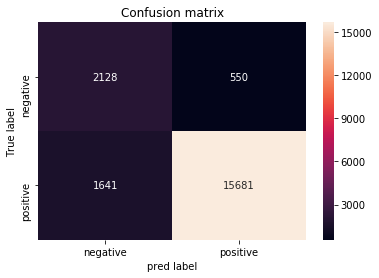

In [26]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm=pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

#MultiCollinearty check

In [54]:
X_train, y_train = final['cleaned_Text'].iloc[0:80000], final['Score'].iloc[0:80000]
#X_cv, y_cv = final['cleaned_Text'].iloc[60000:80000], final['Score'].iloc[60000:80000]
X_test, y_test = final['cleaned_Text'].iloc[80000:100000], final['Score'].iloc[80000:100000]

#BoW
count_vect = CountVectorizer()
count_vect.fit(X_train)
X_train=count_vect.transform(X_train)
#X_cv=count_vect.transform(X_cv)
X_test=count_vect.transform(X_test)
#print(X_train.shape,X_test.shape)

#Standerdized the data
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

#logistic regression-l2 regularization
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(penalty='l2',C=1.0)
LR.fit(X_train,y_train)



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
w = LR.coef_
w


array([[ 1.02910381e-03,  9.29137999e-03,  7.16708496e-02, ...,
        -1.58613403e-01,  1.22470477e-05,  7.14729687e-03]])

In [64]:
w.all()

True

In [65]:
length=w.shape[1]

In [66]:
#adding noise
import numpy as np

Noise=np.random.normal(loc=0.0,scale=0.10)
X_train.data= X_train.data + Noise


In [67]:
#logistic regression-l2 regularization
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(penalty='l2',C=1.0)
LR.fit(X_train,y_train)




LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [68]:
w1 = LR.coef_
w1



array([[ 1.04782015e-03,  9.86650957e-03,  6.37778491e-02, ...,
        -1.44333763e-01,  1.82862920e-05,  5.70574318e-03]])

In [69]:
w1.all()

True

In [73]:
from scipy import spatial
def isMultic(w,w1,length):
    count = 0
    d=spatial.distance.euclidean(w,w1)
    print(f'\n Euc.distance between w vctors after perturbation is {d}')
    cos_d=spatial.distance.cosine(w,w1)
    print(f'\n cosine similarity b/w after perturbation is {cos_d}')
    
    for i in range(0,length-1):
        x =(abs(w[:,i]-w1[:,i]))/w[:i]
        x.all()
        if (x.all() >= 0.3):
            count+=1
    if(count!=0):
          print(f'\n{count} number of features out of {length} are multicollinear as they vary by more than 30% after perturbation')
    

In [74]:
isMultic(w,w1,length)


 Euc.distance between w vctors after perturbation is 4.65378813831177

 cosine similarity b/w after perturbation is 0.003030973250453317

67316 number of features out of 67317 are multicollinear as they vary by more than 30% after perturbation


 # Logistic regression-l1 regularization

In [20]:

from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
my_cv = [(X_train,X_test) for X_train, X_test in TimeSeriesSplit(n_splits=3).split(X_train)]

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'accuracy', cv=my_cv)
model.fit(X_train, y_train)

print(model.best_estimator_)


print("Test_score")
print(model.score(X_test,y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Test_score
0.9213


In [21]:
print("Train_score")
print(model.score(X_train,y_train))

Train_score
0.9512625


In [22]:
print('Best Parameters')
print(model.best_params_)

Best Parameters
{'C': 1}


In [32]:
#logistic regression-l1 regularization
LR = LogisticRegression(penalty='l1',C=1.0,class_weight='balanced')# lambda=1
LR.fit(X_train,y_train)
pred = LR.predict(X_test)
acc=accuracy_score(y_test,pred)

print('accuracy for C=1 is %0.3f' %(acc))


accuracy for C=1 is 0.887


In [33]:


from sklearn.metrics import f1_score
print("f1:", f1_score(y_test, pred,average='micro'))


f1: 0.88705


 # Confusion Matrix

In [24]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[ 2130,   548],
       [ 1697, 15625]])

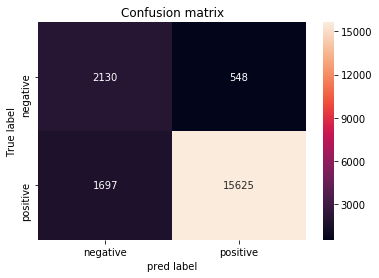

In [25]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm=pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

In [ ]:
#report -performance as lambda inc.-effect on sparcity and error..........with diffrent values of c

In [40]:

#sparcity-1
LR1 = LogisticRegression(penalty='l1',C=1,class_weight='balanced')# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))



Test_accu: 0.88725
5668


In [98]:
#sparcity-2
LR1 = LogisticRegression(penalty='l1',C=0.1,class_weight='balanced')# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))


Test_accu: 0.9159
840


In [41]:
#sparcity-3
LR1 = LogisticRegression(penalty='l1',C=0.01,class_weight='balanced')# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))


Test_accu: 0.82295
244


In [42]:
#sparcity-4
LR1 = LogisticRegression(penalty='l1',C=0.001,class_weight='balanced')# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))


Test_accu: 0.6755
19


 # Random Search CV-BoW

#L2 regularization

In [130]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
#tuned_parameter = [{'C': [10**-3, 10**-2, 10**0, 10**2, 10**3]}]
tuned_parameter = {'C':uniform()}
model1 = RandomizedSearchCV(LogisticRegression(penalty='l2'),tuned_parameters, scoring = 'accuracy', cv=5)
model1.fit(X_train,y_train)
print(model1.best_estimator_)


LogisticRegression(C=0.394831538887219, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [131]:
print(model1.best_params_)

{'C': 0.394831538887219}


In [132]:
print(model1.score(X_test,y_test))

0.9228


In [133]:
print(model1.score(X_train,y_train))

0.952875


In [34]:
#logistic regression-l2 regularization
LR = LogisticRegression(penalty='l2',C=0.394831538887219,class_weight='balanced')# put the correct c - =..........
LR.fit(X_train,y_train)
pred = LR.predict(X_test)
acc=accuracy_score(y_test,pred)
#clf.score(X,y)
print('accuracy for C=0.394831538887219 is %0.3f' %(acc))


accuracy for C=0.394831538887219 is 0.888


In [35]:
from sklearn.metrics import f1_score
print("f1:", f1_score(y_test, pred,average='micro'))

f1: 0.8878499999999999


In [36]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[ 2201,   477],
       [ 1766, 15556]])

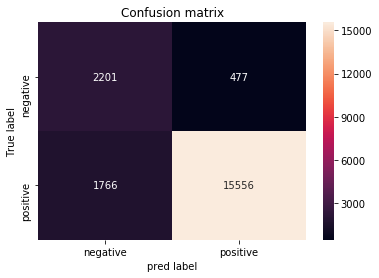

In [37]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm=pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

 # logistic regression-l1 regularization-RandomSearchCV

In [138]:
from sklearn.model_selection import RandomizedSearchCV
#tuned_parameter = [{'C': [10**-3, 10**-2, 10**0, 10**2, 10**3]}]
from scipy.stats import uniform
tuned_parameter = {'C':uniform()}
model1 = RandomizedSearchCV(LogisticRegression(penalty='l1'),tuned_parameters, scoring = 'accuracy', cv=5)
model1.fit(X_train,y_train)
print(model1.best_estimator_)


LogisticRegression(C=0.3486568554875855, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [139]:
print(model1.score(X_test,y_test))

0.92115


In [140]:
print(model1.score(X_train,y_train))

0.9377125


In [38]:
#logistic regression-l1 regularization
LR = LogisticRegression(penalty='l1',C=0.3486568554875855,class_weight='balanced')# put the correct c - =..........
LR.fit(X_train,y_train)
pred = LR.predict(X_test)
acc=accuracy_score(y_test,pred)
#clf.score(X,y)
print('accuracy for C=0.3486568554875855 is %0.3f' %(acc))

accuracy for C=0.3486568554875855 is 0.879


In [39]:
from sklearn.metrics import f1_score
print("f1:", f1_score(y_test, pred,average='micro'))


f1: 0.8785999999999999


In [109]:
#report-

In [142]:
#sparcity-1
LR1 = LogisticRegression(penalty='l1',C=1.0)# lambda=1
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))



Test_accu: 0.9213
4141


In [143]:
#sparcity-2
LR1 = LogisticRegression(penalty='l1',C=0.1)# lambda = 10
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.9159
840


In [144]:
#sparcity-3
LR1 = LogisticRegression(penalty='l1',C=0.01)# lambda = 100
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test accu: 0.88695
132


In [145]:
#sparcity-4
LR1 = LogisticRegression(penalty='l1',C=0.001)# lambda = 1000
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.8661
7


   # 2.TFIDF-

In [96]:

X_train, y_train = final['cleaned_Text'].iloc[0:80000], final['Score'].iloc[0:80000]
#X_cv, y_cv = final['cleaned_Text'].iloc[60000:80000], final['Score'].iloc[60000:80000]
X_test, y_test = final['cleaned_Text'].iloc[80000:100000], final['Score'].iloc[80000:100000]



#Initializing tfidf vectorizer
tfidf_vect = TfidfVectorizer()

#Fitting for tfidf vectorization
tfidf_vect.fit(X_train)
X_train= tfidf_vect.transform(X_train)
X_test = tfidf_vect.transform(X_test)
#X_cv = tfidf_vect.transform(X_cv)
X_train.shape,y_train.shape

((80000, 67317), (80000,))

In [97]:
#Standerdized the data
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

<20000x67317 sparse matrix of type '<class 'numpy.float64'>'
	with 580348 stored elements in Compressed Sparse Row format>

 # GridSearchCV-TFIDF

In [148]:
%%time
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
my_cv = [(X_train,X_test) for X_train, X_test in TimeSeriesSplit(n_splits=5).split(X_train)]

tuned_parameters = [{'C': [10**-3, 10**-2, 10**0, 10**2, 10**3]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'accuracy', cv=my_cv)
model.fit(X_train, y_train)



print("best estimator:")
print(model.best_estimator_)





best estimator:
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
CPU times: user 9min 49s, sys: 8.95 s, total: 9min 58s
Wall time: 1min 15s


In [63]:
print("best parameter")
print(model.best_params_)

best parameter
{'C': 1}


In [64]:
print(model.score(X_train,y_train))

0.9363


In [65]:
print(model.score(X_test,y_test))

0.91925


In [42]:
#logistic regression-l2 regularization
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(penalty='l2',C=1.0,class_weight='balanced')
LR.fit(X_train,y_train)

#print('\n ****Test accuracy for C=1.0 is %.3f' %(acc))

pre = LR.predict(X_train)
error= 1-(accuracy_score(pre,y_train))


pred = LR.predict(X_test)
print("Test accuracy:")
acc=accuracy_score(y_test,pred)
print('\n ****Test accuracy for C=1.0 is %.3f' %(acc))


Test accuracy:

 ****Test accuracy for C=1.0 is 0.880


In [43]:
from sklearn.metrics import f1_score
print("f1:", f1_score(y_test, pred,average='micro'))

f1: 0.87955


In [69]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[ 2322,   356],
       [ 2053, 15269]])

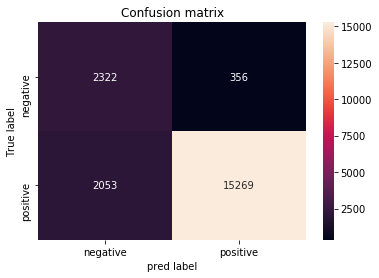

In [70]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm = pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

# GridSearch-Logistic Reg.-L1 regularization-TFIDF

In [71]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
my_cv = [(X_train,X_test) for X_train, X_test in TimeSeriesSplit(n_splits=5).split(X_train)]

tuned_parameters = [{'C': [10**-3, 10**-2, 10**0, 10**2, 10**3]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'accuracy', cv=my_cv)
model.fit(X_train, y_train)
print(model.best_estimator_)



LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [72]:
print(model.score(X_train,y_train))

0.9344875


In [73]:
print(model.score(X_test,y_test))

0.92155


In [74]:
#logistic regression-l1 regularization
LR = LogisticRegression(penalty='l1',C=1.0,class_weight='balanced')# put the correct c - =..........
LR.fit(X_train,y_train)
pred = LR.predict(X_test)
acc=accuracy_score(y_test,pred)
#clf.score(X,y)
print('accuracy for C=1 is %0.3f' %(acc))

accuracy for C=1 is 0.874


In [125]:
from sklearn.metrics import f1_score
print("f1:", f1_score(y_test, pred,average='micro'))

accuracy: 0.92155
pre: 0.92155
rec: 0.92155
f1: 0.92155


In [ ]:
#Confusion Matrix

In [75]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[ 2319,   359],
       [ 2169, 15153]])

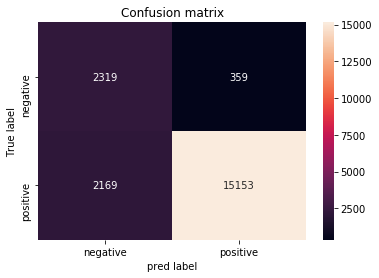

In [76]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm = pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

In [77]:
#sparcity-1
LR1 = LogisticRegression(penalty='l1',C=1,class_weight='balanced')# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))



Test_accu: 0.8736
2546


In [78]:
#sparcity-2
LR1 = LogisticRegression(penalty='l1',C=0.1,class_weight='balanced')# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))



Test_accu: 0.8364
366


In [79]:
#sparcity-3
LR1 = LogisticRegression(penalty='l1',C=0.01,class_weight='balanced')# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))



Test_accu: 0.67665
25


# observation- as lambda increases  the sparcity also increased.

#MultiCollinearty Check

In [124]:
X_train, y_train = final['cleaned_Text'].iloc[0:80000], final['Score'].iloc[0:80000]
#X_cv, y_cv = final['cleaned_Text'].iloc[60000:80000], final['Score'].iloc[60000:80000]
X_test, y_test = final['cleaned_Text'].iloc[80000:100000], final['Score'].iloc[80000:100000]



#Initializing tfidf vectorizer
tfidf_vect = TfidfVectorizer()

#Fitting for tfidf vectorization
tfidf_vect.fit(X_train)
X_train= tfidf_vect.transform(X_train)
X_test = tfidf_vect.transform(X_test)



#Standerdized the data
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

#logistic regression-l2 regularization
from sklearn.linear_model import LogisticRegression
LR22 = LogisticRegression(penalty='l2',C=1.0)
LR22.fit(X_train,y_train)




LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [125]:
w = LR22.coef_
w

array([[ 0.01537182,  0.01250393,  0.04710226, ..., -0.19692034,
         0.00292042,  0.01000527]])

In [126]:
w.all()

True

In [127]:
length=w.shape[1]

In [128]:
#adding noise
import numpy as np

Noise=np.random.normal(loc=0.0,scale=0.10)
X_train.data= X_train.data + Noise


In [129]:
#logistic regression-l2 regularization
from sklearn.linear_model import LogisticRegression
LR33 = LogisticRegression(penalty='l2',C=1.0)
LR33.fit(X_train,y_train)




LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [131]:
w_new = LR33.coef_
w_new

array([[ 0.01067377,  0.01228999,  0.06060293, ..., -0.18549989,
         0.00064414,  0.00880867]])

In [132]:
w_new.all()

True

In [133]:
from scipy import spatial
def isMultic(w,w_new,length):
    count = 0
    d=spatial.distance.euclidean(w,w_new)
    print(f'\n Euc.distance between w vctors after perturbation is {d}')
    cos_d=spatial.distance.cosine(w,w_new)
    print(f'\n cosine similarity b/w after perturbation is {cos_d}')
    
    for i in range(0,length-1):
        x =(abs(w[:,i]-w_new[:,i]))/w[:i]
        x.all()
        if (x.all() >= 0.3):
            count+=1
    if(count!=0):
          print(f'\n{count} number of features out of {length} are multicollinear as they vary by more than 30% after perturbation')
    

In [134]:
isMultic(w,w_new,length)


 Euc.distance between w vctors after perturbation is 17.746218415753244

 cosine similarity b/w after perturbation is 0.0323265483942744

67316 number of features out of 67317 are multicollinear as they vary by more than 30% after perturbation


# RandomSearch-l2 regu,TFIDF

In [61]:
from sklearn.model_selection import RandomizedSearchCV
#tuned_parameter = [{'C': [10**-3, 10**-2, 10**0, 10**2, 10**3]}]
from scipy.stats import uniform
tuned_parameters = {'C':uniform()}
model1 = RandomizedSearchCV(LogisticRegression(penalty='l2'),tuned_parameters, scoring = 'accuracy', cv=5)
model1.fit(X_train,y_train)
print(model1.best_estimator_)
print(model1.score(X_test,y_test))

LogisticRegression(C=0.9236509189606253, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9059


In [62]:
print(model1.score(X_train,y_train))

0.9477


In [64]:
#logistic regression-l2 regularization
LR = LogisticRegression(penalty='l2',C=0.9236509189606253,class_weight='balanced')
LR.fit(X_train,y_train)
pred = LR.predict(X_test)
acc=accuracy_score(y_test,pred)
#clf.score(X,y)
print('accuracy for C=0.9236509189606253 is %0.3f' %(acc))


accuracy for C=0.9236509189606253 is 0.853


In [65]:
from sklearn.metrics import f1_score
print("f1:", f1_score(y_test, pred,average='micro'))

f1: 0.8533


In [66]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[ 2377,   301],
       [ 2633, 14689]])

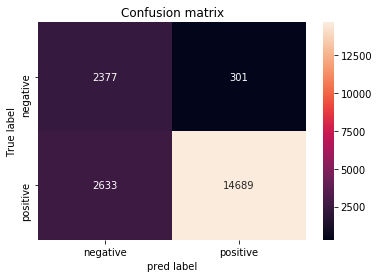

In [67]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm = pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

# RanndomSearch-L1-TFIDF

In [68]:
from sklearn.model_selection import RandomizedSearchCV
#tuned_parameter = [{'C': [10**-3, 10**-2, 10**0, 10**2, 10**3]}]
from scipy.stats import uniform
tuned_parameters = {'C':uniform()}
model1 = RandomizedSearchCV(LogisticRegression(penalty='l1'),tuned_parameters, scoring = 'accuracy', cv=5)
model1.fit(X_train,y_train)
print(model1.best_estimator_)
print(model1.score(X_test,y_test))

LogisticRegression(C=0.8543294440114568, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9073


In [69]:
print(model1.score(X_train,y_train))

0.9389


In [70]:
#logistic regression-l1 regularization
LR = LogisticRegression(penalty='l1',C=0.8543294440114568,class_weight='balanced')# put the correct c - =..........
LR.fit(X_train,y_train)
pred = LR.predict(X_test)
acc=accuracy_score(y_test,pred)
#clf.score(X,y)
print('accuracy for C=0.8543294440114568 is %0.3f' %(acc))

accuracy for C=0.8543294440114568 is 0.843


In [71]:
from sklearn.metrics import f1_score
print("f1:", f1_score(y_test, pred,average='micro'))

f1: 0.84315


In [141]:
#sparcity-1
LR1 = LogisticRegression(penalty='l1',C=1.0)# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.9215
1380


In [143]:
#sparcity-2
LR1 = LogisticRegression(penalty='l1',C=0.1)# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.8954
208


In [144]:
#sparcity-3
LR1 = LogisticRegression(penalty='l1',C=0.01)# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.8661
5


 # 3. Word2Vec

In [136]:
import re

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [137]:
#Train your own Word2Vec model using your own train text corpus
#spliting the data
X_train, y_train = final['cleaned_Text'].iloc[0:80000],final['Score'].iloc[0:80000]
X_test, y_test = final['cleaned_Text'].iloc[80000:100000],final['Score'].iloc[80000:100000]
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
    

(80000,) (80000,) (20000,) (20000,)


In [138]:
import gensim
from gensim import utils
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from gensim import parsing, corpora, matutils, interfaces, models, similarities, summarization, utils


train_sent=[]

for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    train_sent.append(filtered_sentence)
print(len(train_sent))

80000


In [139]:
test_sent=[]

for sent in X_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    test_sent.append(filtered_sentence)
print(len(test_sent))

20000


In [140]:
train_w2v_model = gensim.models.Word2Vec(train_sent,min_count=5,size=50,workers=4)
train_words = list(train_w2v_model.wv.vocab)
print(len(train_words))

11901


3.1 Avg-W2v

In [141]:
#avg w2v
#Avg-w2v for train data
from tqdm import tqdm
import os
train_vectors = []
for sent in tqdm(train_sent):
    train_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec=train_w2v_model.wv[word]
            train_vec+=vec
            cnt_words+=1
        except:
            pass
    train_vec/=cnt_words
    train_vectors.append(train_vec)
print(len(train_vectors))
print(len(train_vectors[0]))


100%|██████████| 80000/80000 [00:12<00:00, 6455.64it/s]

80000
50


In [142]:
%%time
#Avg-w2v for test data
test_vectors = []
for sent in tqdm(test_sent):
    test_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec=train_w2v_model.wv[word]
            test_vec+=vec
            cnt_words+=1
        except:
            pass
    test_vec/=cnt_words
    test_vectors.append(test_vec)
print(len(test_vectors))
print(len(test_vectors[0]))


100%|██████████| 20000/20000 [00:03<00:00, 6123.34it/s]

20000
50
CPU times: user 3.27 s, sys: 40.5 ms, total: 3.31 s
Wall time: 3.27 s


In [143]:
X_train = train_vectors

X_test = test_vectors
len(X_train)
len(y_train)

80000

In [144]:
#Standerdized the data
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

array([[ 1.63180629,  0.39932045,  1.02807267, ..., -0.0922089 ,
        -1.13215294,  3.04350469],
       [ 1.1692753 ,  1.49175344,  0.5941506 , ..., -1.10295868,
        -0.87434337, -0.3549451 ],
       [ 0.18447295,  2.25891544, -1.84507277, ..., -0.13048696,
         2.77109614, -2.06858988],
       ...,
       [ 0.58170098,  0.72735712,  0.9696042 , ...,  1.0074779 ,
         0.73944126, -1.59095292],
       [ 1.11519122,  1.41023525,  0.26501797, ..., -0.60545048,
         0.9296049 ,  1.52944836],
       [ 0.52294205,  0.54464731, -0.48675631, ...,  0.18748582,
         0.59550014, -0.33342192]])

  # GridSearch -L2-AvgW2V

In [82]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
my_cv = [(X_train,X_test) for X_train, X_test in TimeSeriesSplit(n_splits=5).split(X_train)]

tuned_parameters = [{'C': [10**-3, 10**-2, 10**0, 10**2, 10**3]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'accuracy', cv=my_cv)
model.fit(X_train, y_train)

print(model.best_estimator_)
print("Best parameter")
print(model.best_params_)

print("score")
print(model.score(X_test,y_test))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best parameter
{'C': 100}
score
0.89345


In [83]:
print(model.score(X_train,y_train))

0.9048375


In [84]:
#logistic regression-l2 regularization
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(penalty='l2',C=100,class_weight='balanced')# put the correct c - =..........
LR.fit(X_train,y_train)
pre = LR.predict(X_train)
error= 1-(accuracy_score(pre,y_train))
#Train score
score=model.score(X_train,y_train)


#Test score

pred = LR.predict(X_test)
#Test score
score1 = model.score(X_test,y_test)
acc=accuracy_score(y_test,pred)
#clf.score(X,y)
print('\n ****Test accuracy for C=100 is %.3f' %(acc))
#print('accuracy for C=%f is %f' %(acc))


 ****Test accuracy for C=100 is 0.796


In [85]:
from sklearn.metrics import f1_score
print("f1:", f1_score(y_test, pred,average='micro'))

f1: 0.7962


In [92]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[ 2287,   391],
       [ 3617, 13705]])

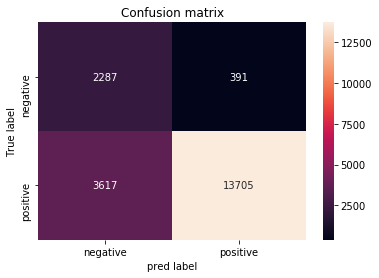

In [93]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm = pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

# Gridsearch-l1 regu-Avgw2v

In [86]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
my_cv = [(X_train,X_test) for X_train, X_test in TimeSeriesSplit(n_splits=3).split(X_train)]

tuned_parameters = [{'C': [10**-3, 10**-2, 10**0, 10**2, 10**3]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'accuracy', cv=my_cv)
model.fit(X_train, y_train)
print(model.best_estimator_)
#Using GridSearchCV
print(model.score(X_test,y_test))

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8934


In [87]:
print(model.score(X_train,y_train))

0.9048375


In [88]:
#logistic regression-l1 regularization
LR = LogisticRegression(penalty='l1',C=1000,class_weight='balanced')
LR.fit(X_train,y_train)
pred = LR.predict(X_test)
acc=accuracy_score(y_test,pred)
#clf.score(X,y)
print('accuracy for C=1000 is %0.3f' %(acc))

accuracy for C=1000 is 0.796


In [89]:

from sklearn.metrics import f1_score
print("f1:", f1_score(y_test, pred,average='micro'))

f1: 0.79625


In [90]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[ 2280,   398],
       [ 3677, 13645]])

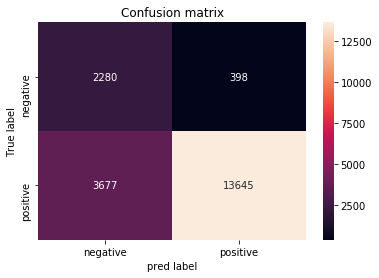

In [91]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm = pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

In [100]:
#sparcity-1
import numpy as np
LR1 = LogisticRegression(penalty='l1',C=1.0)# lambda = 1
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.89485
50


In [101]:
print(w)

[[ 0.29146099  0.12218821  0.08940939 -0.65411473 -0.72212911 -0.099033
   1.08594798 -0.44602102  0.22066904 -0.15438553 -0.05980652  1.03540926
   0.12007903  0.31495175 -0.16407808 -0.39830847 -0.11143905 -1.6456916
   0.3447787   0.40050946  0.21582881  0.65087015  0.88402148  0.93974455
  -0.58336997  1.36095739 -0.28562453  0.33810518  0.03013348  0.25517082
   0.60638862  0.22475938 -0.09656852  0.35908045 -0.51211332 -1.24940464
   0.7993659   0.65124688  1.05145569  0.09085519  0.51992926  0.12944027
   0.00337069  1.38830844  1.12466781  0.89547834  0.25578875  0.75175384
  -1.09858766  0.43062325]]


In [102]:
#sparcity-2
LR2 = LogisticRegression(penalty='l1',C=0.1)# lambda = 10
LR2.fit(X_train,y_train)
pred1=LR2.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR2.coef_
print(np.count_nonzero(w))

Test_accu: 0.8947
48


In [59]:
#sparcity-3
LR1 = LogisticRegression(penalty='l1',C=.01)# lambda = 100
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.8915
36


In [60]:
#sparcity-4
LR1 = LogisticRegression(penalty='l1',C=.001)# lambda = 1000
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test accu: 0.86785
14


# RandomSearch-l2-AvgW2V

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
#tuned_parameter = [{'C': [10**-3, 10**-2, 10**0, 10**2, 10**3]}]
from scipy.stats import uniform
tuned_parameters = {'C':uniform()}
model1 = RandomizedSearchCV(LogisticRegression(penalty='l2'),tuned_parameters, scoring = 'accuracy', cv=5)
model1.fit(X_train,y_train)




RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc0e0729c18>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [93]:
print(model1.score(X_test,y_test))

0.89385


In [94]:
print(model1.score(X_train,y_train))

0.904775


In [95]:
print(model1.best_params_)

{'C': 0.21175748685407292}


In [96]:
#logistic regression-l2 regularization
LR = LogisticRegression(penalty='l2',C=0.21175748685407292,class_weight='balanced')# put the correct c - =..........
LR.fit(X_train,y_train)
pred = LR.predict(X_test)
acc=accuracy_score(y_test,pred)
#clf.score(X,y)
print('accuracy for C=0.21175748685407292 is %0.3f' %(acc))


accuracy for C=0.21175748685407292 is 0.796


In [97]:
from sklearn.metrics import f1_score
print("f1:", f1_score(y_test, pred,average='micro'))

f1: 0.7956999999999999


In [98]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[ 2276,   402],
       [ 3684, 13638]])

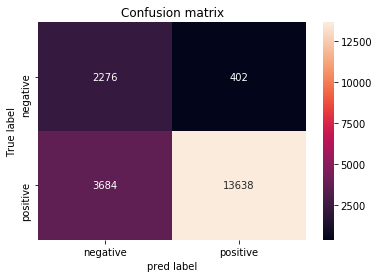

In [99]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm = pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

# RandomSearch-L1-AvgW2V

In [145]:
from sklearn.model_selection import RandomizedSearchCV
#tuned_parameter = [{'C': [10**-3, 10**-2, 10**0, 10**2, 10**3]}]
from scipy.stats import uniform
tuned_parameters = {'C':uniform()}
model1 = RandomizedSearchCV(LogisticRegression(penalty='l1'),tuned_parameters, scoring = 'accuracy', cv=5)
model1.fit(X_train,y_train)
print(model1.best_estimator_)
print(model1.score(X_test,y_test))

LogisticRegression(C=0.33650973319443533, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.89395


In [146]:
print(model1.best_params_)

{'C': 0.33650973319443533}


In [148]:
print(model1.score(X_train,y_train))

0.9042875


In [149]:
print(model1.score(X_test,y_test))

0.89395


In [150]:
#logistic regression-l1 regularization
LR = LogisticRegression(penalty='l1',C=0.33650973319443533,class_weight='balanced')
LR.fit(X_train,y_train)
pred = LR.predict(X_test)
acc=accuracy_score(y_test,pred)
#clf.score(X,y)
print('accuracy for C=0.33650973319443533 is %0.3f' %(acc))


accuracy for C=0.33650973319443533 is 0.797


In [151]:

from sklearn.metrics import f1_score

print("f1:", f1_score(y_test, pred,average='micro'))

f1: 0.7967


In [152]:
#sparcity-1
LR1 = LogisticRegression(penalty='l1',C=1)# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.89395
50


In [153]:
#sparcity-2
LR1 = LogisticRegression(penalty='l1',C=.1)# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.89385
48


In [154]:
#sparcity-3
LR1 = LogisticRegression(penalty='l1',C=.01)# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.89045
37


In [155]:
#sparcity-4
LR1 = LogisticRegression(penalty='l1',C=.001)# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.8686
12


 # 3.2 TFIDF-W2V-GridSearchCV

In [156]:
X_train, y_train = final['cleaned_Text'].iloc[0:80000], final['Score'].iloc[0:80000]
X_test, y_test = final['cleaned_Text'].iloc[80000:100000], final['Score'].iloc[80000:100000]

# Initializing tfidf vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))

# Fitting for tfidf vectorization
tfidf_vect.fit(X_train)
X_train = tfidf_vect.transform(X_train)
X_test = tfidf_vect.transform(X_test)

#we are converting dictionary with word as key and idf as value
dictionary = dict(zip(tfidf_vect.get_feature_names(),list(tfidf_vect.idf_)))
print(X_train.shape,y_train.shape)

(80000, 67317) (80000,)


In [157]:
%%time
tfidf_feat = tfidf_vect.get_feature_names()
tfidf_train_vectors = []
row = 0
for sent in tqdm(train_sent):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = train_w2v_model.wv[word]
            #tf_idf = X_train[row, tfidf_feat.index(word)](prev.............)
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1

100%|██████████| 80000/80000 [00:26<00:00, 3026.48it/s]

CPU times: user 27.4 s, sys: 1.78 s, total: 29.2 s
Wall time: 26.5 s


In [158]:
len(tfidf_train_vectors)

80000

In [160]:
#tfidf w2v for test data

tfidf_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in test_sent: # for each review/sentence
    test_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = train_w2v_model.wv[word]
            # obtain the tf_idf of a word in a sentence/review
            #tf_idf = X_test[row, tfidf_feat.index(word)]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            test_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    test_vec /= weight_sum
    tfidf_test_vectors.append(test_vec)
    row += 1
len(tfidf_test_vectors)

20000

In [161]:
X_train = tfidf_train_vectors
X_test = tfidf_test_vectors 
len(X_train)


80000

In [162]:
#Standerdized the data
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

array([[ 1.55229409,  0.09916706,  0.88940091, ..., -0.07003348,
        -0.80218799,  2.24317512],
       [ 1.52570008,  1.26890618,  0.59305125, ..., -0.37149939,
        -0.44498053,  0.21146913],
       [ 0.16732122,  1.34952216, -1.2159911 , ..., -0.13748329,
         1.76522872, -1.36214961],
       ...,
       [ 0.15175289,  1.1483961 ,  1.97744671, ...,  1.60645729,
         1.30597261, -2.32972197],
       [ 1.35267827,  1.18015889,  0.1211857 , ..., -0.36018084,
         1.19428448,  1.0550643 ],
       [ 0.58834828,  1.0098456 , -0.37140392, ...,  0.12622902,
         0.44553564, -0.6915908 ]])

# GridSearch L2-TFIDF-W2V

In [163]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
my_cv = [(X_train,X_test) for X_train, X_test in TimeSeriesSplit(n_splits=5).split(X_train)]

tuned_parameters = [{'C': [10**-3, 10**-2, 10**0, 10**2, 10**3]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'accuracy', cv=my_cv)
model.fit(X_train, y_train)
print(model.best_estimator_)

print("best parameter")
print(model.best_params_)

print("Test score")
print(model.score(X_test,y_test)) 

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
best parameter
{'C': 100}
Test score
0.8851


In [164]:
print(model.score(X_train,y_train))

0.8959875


In [165]:
#logistic regression-l2 regularization
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(penalty='l2',C=100,class_weight='balanced')# put the correct c - =..........
LR.fit(X_train,y_train)
p=LR.predict(X_train)
error = 1-accuracy_score(p,y_train)
#train score
score = model.score(X_train,y_train)

pred = LR.predict(X_test)
acc=accuracy_score(y_test,pred)
#Test score
score1= model.score(X_test,y_test)
#clf.score(X,y)
print('\n ****Test accuracy for C=100 is %.3f' %(acc))
#print('accuracy for C=%f is %f' %(acc))


 ****Test accuracy for C=100 is 0.773


In [166]:
from sklearn.metrics import f1_score
print("f1:", f1_score(y_test, pred,average='micro'))

f1: 0.7728500000000001


In [110]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[ 2196,   482],
       [ 4028, 13294]])

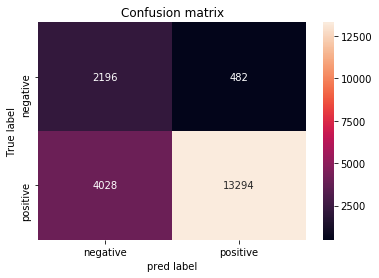

In [111]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm = pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

# GridSearch L1-TFIDFW2V

In [189]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
my_cv = [(X_train,X_test) for X_train, X_test in TimeSeriesSplit(n_splits=5).split(X_train)]

tuned_parameters = [{'C': [10**-3, 10**-2, 10**0, 10**2, 10**3]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'accuracy', cv = my_cv)
model.fit(X_train, y_train)
print(model.best_estimator_)

print(model.score(X_test,y_test))

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.885


In [191]:
print(model.score(X_train,y_train))

0.895975


In [192]:
#logistic regression-l1 regularization
LR = LogisticRegression(penalty='l1',C=1000,class_weight='balanced')
LR.fit(X_train,y_train)
pred = LR.predict(X_test)
acc=accuracy_score(y_test,pred)
#clf.score(X,y)
print('accuracy for C=1000 is %0.3f' %(acc))

accuracy for C=1000 is 0.773


In [193]:
from sklearn.metrics import f1_score
print("f1:", f1_score(y_test, pred,average='micro'))

f1: 0.7728


In [194]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[ 2185,   493],
       [ 4051, 13271]])

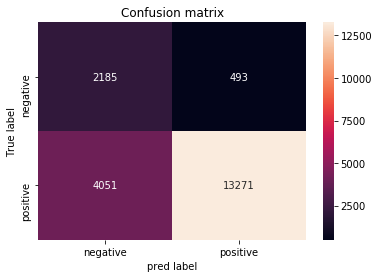

In [195]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm = pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

In [196]:
#sparcity-1
LR1 = LogisticRegression(penalty='l1',C=1)# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.8852
50


In [197]:
#sparcity-2
LR1 = LogisticRegression(penalty='l1',C=0.1)# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.8847
49


In [198]:
#sparcity-3
LR1 = LogisticRegression(penalty='l1',C=0.01)# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.8817
39


In [199]:
#sparcity-4
LR1 = LogisticRegression(penalty='l1',C=0.001)# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.86675
16


# RandomSearch-L2-TFIDF-W2V

In [169]:

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
#tuned_parameter = [{'C': [10**-3, 10**-2, 10**0, 10**2, 10**3]}]
tuned_parameters = {'C':uniform()}
model1 = RandomizedSearchCV(LogisticRegression(penalty='l2'),tuned_parameters, scoring = 'accuracy', cv=5)
model1.fit(X_train,y_train)
print(model1.best_estimator_)
print(model1.score(X_test,y_test))

LogisticRegression(C=0.8899734763979731, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.885


In [170]:
print(model.score(X_train,y_train))

0.8959875


In [171]:
print(model.score(X_train,y_train))

0.8959875


In [173]:
#logistic regression-l2 regularization
LR = LogisticRegression(penalty='l2',C=0.8899734763979731,class_weight='balanced')
LR.fit(X_train,y_train)
pred = LR.predict(X_test)
acc=accuracy_score(y_test,pred)
#clf.score(X,y)
print('accuracy for C=0.8899734763979731 is %0.3f' %(acc))


accuracy for C=0.8899734763979731 is 0.773


In [174]:
from sklearn.metrics import f1_score
print("f1:", f1_score(y_test, pred,average='micro'))

f1: 0.77315


In [175]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[ 2186,   492],
       [ 4045, 13277]])

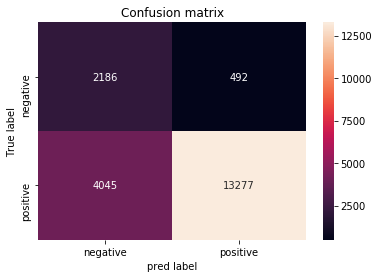

In [176]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm = pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

 # RandomSearch-L1-Tfidf-W2V

In [177]:


from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
#tuned_parameter = [{'C': [10**-3, 10**-2, 10**0, 10**2, 10**3]}]
tuned_parameters = {'C':uniform()}
model1 = RandomizedSearchCV(LogisticRegression(penalty='l1'),tuned_parameters, scoring = 'accuracy', cv=5)
model1.fit(X_train,y_train)
print(model1.best_estimator_)


LogisticRegression(C=0.5804536923497893, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.88495


In [179]:
print(model1.score(X_test,y_test))

0.88495


In [178]:
print(model.score(X_train,y_train))

0.8959875


In [183]:
#logistic regression-l1 regularization
LR = LogisticRegression(penalty='l1',C=0.5804536923497893,class_weight='balanced')
LR.fit(X_train,y_train)
pred = LR.predict(X_test)
acc=accuracy_score(y_test,pred)
#clf.score(X,y)
print('accuracy for C=0.5804536923497893 is %0.3f' %(acc))


accuracy for C=0.5804536923497893 is 0.773


In [184]:
from sklearn.metrics import f1_score
print("f1:", f1_score(y_test, pred,average='micro'))

f1: 0.77275


In [185]:
#sparcity-1
LR1 = LogisticRegression(penalty='l1',C=1.0)# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.8852
50


In [186]:
#sparcity-2
LR1 = LogisticRegression(penalty='l1',C=0.1)# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.8847
49


In [187]:
#sparcity-3
LR1 = LogisticRegression(penalty='l1',C=0.01)# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.88165
39


In [188]:
#sparcity-4
LR1 = LogisticRegression(penalty='l1',C=0.001)# put the correct c - =..........
LR1.fit(X_train,y_train)
pred1=LR1.predict(X_test)
Test_acc = accuracy_score(y_test,pred1)
print("Test_accu:",Test_acc)
w = LR1.coef_
print(np.count_nonzero(w))

Test_accu: 0.86675
16


 # Conclusion-


  1.as lambda increases ,Model will be underfit But with L1-regularization, we get more sparcity.



In [200]:
#from prettytable import prettyTable

from prettytable import PrettyTable
Table1=PrettyTable()
Table1.field_names=['Model','Vectorizor','Regularizor','Techniqe','Test_accuracy','Test_score','Train_score','Best_param','f1_score']
Table1.add_row(['LOgistic R','BOW',       'L2' ,'GridSearh', .890, 0.9205 , 0.9628,  1  , 0.8904])
Table1.add_row(['Logistic R','BOW',        'L1' ,'GridSearch',.898, 0.9213, 0.9512,  1  , 0.8871])
Table1.add_row(['Logistic R','BOW',       'L2', 'RandomSearch',.885,0.9218, 0.9528, 0.3948, 0.8878])
Table1.add_row(['Logistic R','BOW',      'L1','RandomSearch',.878, 0.92125, 0.9377, 0.34860, 0.8785])

print(Table1)

+------------+------------+-------------+--------------+---------------+------------+-------------+------------+----------+
|   Model    | Vectorizor | Regularizor |   Techniqe   | Test_accuracy | Test_score | Train_score | Best_param | f1_score |
+------------+------------+-------------+--------------+---------------+------------+-------------+------------+----------+
| LOgistic R |    BOW     |      L2     |  GridSearh   |      0.89     |   0.9205   |    0.9628   |     1      |  0.8904  |
| Logistic R |    BOW     |      L1     |  GridSearch  |     0.898     |   0.9213   |    0.9512   |     1      |  0.8871  |
| Logistic R |    BOW     |      L2     | RandomSearch |     0.885     |   0.9218   |    0.9528   |   0.3948   |  0.8878  |
| Logistic R |    BOW     |      L1     | RandomSearch |     0.878     |  0.92125   |    0.9377   |   0.3486   |  0.8785  |
+------------+------------+-------------+--------------+---------------+------------+-------------+------------+----------+


In [181]:
#from prettytable import prettyTable

from prettytable import PrettyTable
Table2=PrettyTable()
Table2.field_names=['Model','Vectorizor','Regularizor','Techniqe','Test_accuracy','Test_score','Train_score','Best_param','f1_score']

Table2.add_row(['LOgistic R.','TFIDF',       'L2' ,'GridSearh',0.880,9193,0.9363,1,0.8795])
Table2.add_row(['Logistic R','TFIDF',       'L1' ,'GridSearch',0.874,0.9213,0.9345,1,0.92155])
Table2.add_row(['Logistic R','TFIDF',   'L2', 'RandomSearch',0.853,0.9059,0.9477,0.9236,0.8533])
Table2.add_row(['Logistic R','TFIDF','L1','RandomSearch',0.843,0.9073,0.9389,0.85432,0.8432])
print(Table2)

+-------------+------------+-------------+--------------+---------------+------------+-------------+------------+----------+
|    Model    | Vectorizor | Regularizor |   Techniqe   | Test_accuracy | Test_score | Train_score | Best_param | f1_score |
+-------------+------------+-------------+--------------+---------------+------------+-------------+------------+----------+
| LOgistic R. |   TFIDF    |      L2     |  GridSearh   |      0.88     |    9193    |    0.9363   |     1      |  0.8795  |
|  Logistic R |   TFIDF    |      L1     |  GridSearch  |     0.874     |   0.9213   |    0.9345   |     1      | 0.92155  |
|  Logistic R |   TFIDF    |      L2     | RandomSearch |     0.853     |   0.9059   |    0.9477   |   0.9236   |  0.8533  |
|  Logistic R |   TFIDF    |      L1     | RandomSearch |     0.843     |   0.9073   |    0.9389   |  0.85432   |  0.8432  |
+-------------+------------+-------------+--------------+---------------+------------+-------------+------------+----------+


In [201]:
#from prettytable import prettyTable

from prettytable import PrettyTable
Table3=PrettyTable()
Table3.field_names=['Model','Vectorizor','Regularizor','Techniqe','Test_accuracy','Test_score','Train_score','Best_param','f1_score']

Table3.add_row(['LOgistic R.','Avg-W2V',       'L2' ,'GridSearh',0.800,0.8934,0.9078,100,0.7962])
Table3.add_row(['Logistic R','Avg-W2V',       'L1' ,'GridSearch',0.790,0.8934,0.90483,1000,0.7963])
Table3.add_row(['Logistic R','Avg-W2V',   'L2', 'RandomSearch',0.796,0.8935,0.9047,0.2117,0.7956])
Table3.add_row(['Logistic R','Avg-W2V','L1','RandomSearch',0.797,0.8939,0.90426,0.3365,0.7967])
print(Table3)

+-------------+------------+-------------+--------------+---------------+------------+-------------+------------+----------+
|    Model    | Vectorizor | Regularizor |   Techniqe   | Test_accuracy | Test_score | Train_score | Best_param | f1_score |
+-------------+------------+-------------+--------------+---------------+------------+-------------+------------+----------+
| LOgistic R. |  Avg-W2V   |      L2     |  GridSearh   |      0.8      |   0.8934   |    0.9078   |    100     |  0.7962  |
|  Logistic R |  Avg-W2V   |      L1     |  GridSearch  |      0.79     |   0.8934   |   0.90483   |    1000    |  0.7963  |
|  Logistic R |  Avg-W2V   |      L2     | RandomSearch |     0.796     |   0.8935   |    0.9047   |   0.2117   |  0.7956  |
|  Logistic R |  Avg-W2V   |      L1     | RandomSearch |     0.797     |   0.8939   |   0.90426   |   0.3365   |  0.7967  |
+-------------+------------+-------------+--------------+---------------+------------+-------------+------------+----------+


In [204]:
#from prettytable import prettyTable

from prettytable import PrettyTable
Table4=PrettyTable()
Table4.field_names=['Model','Vectorizor','Regularizor','Techniqe','Test_accuracy','Test_score','Train_score','Best_param','f1_score']

Table4.add_row(['LOgistic R.','TFIDF-W2V',       'L2' ,'GridSearh',0.773,0.8855,0.8959,100,0.7785])
Table4.add_row(['Logistic R','TFIDF-W2V',       'L1' ,'GridSearch',0.773,0.885,0.8959,1000,0.7728])
Table4.add_row(['Logistic R','TFIDF-W2V',   'L2', 'RandomSearch',0.773,0.885,0.8959,0.8899,0.77315])
Table4.add_row(['Logistic R','TFIDF-W2V','L1','RandomSearch',0.773,0.8849,0.8959,0.5804,0.77275])
print(Table4)

+-------------+------------+-------------+--------------+---------------+------------+-------------+------------+----------+
|    Model    | Vectorizor | Regularizor |   Techniqe   | Test_accuracy | Test_score | Train_score | Best_param | f1_score |
+-------------+------------+-------------+--------------+---------------+------------+-------------+------------+----------+
| LOgistic R. | TFIDF-W2V  |      L2     |  GridSearh   |     0.773     |   0.8855   |    0.8959   |    100     |  0.7785  |
|  Logistic R | TFIDF-W2V  |      L1     |  GridSearch  |     0.773     |   0.885    |    0.8959   |    1000    |  0.7728  |
|  Logistic R | TFIDF-W2V  |      L2     | RandomSearch |     0.773     |   0.885    |    0.8959   |   0.8899   | 0.77315  |
|  Logistic R | TFIDF-W2V  |      L1     | RandomSearch |     0.773     |   0.8849   |    0.8959   |   0.5804   | 0.77275  |
+-------------+------------+-------------+--------------+---------------+------------+-------------+------------+----------+


2. as lambda increases ,Model will be underfit But with L1-regularization, we get more sparcity.